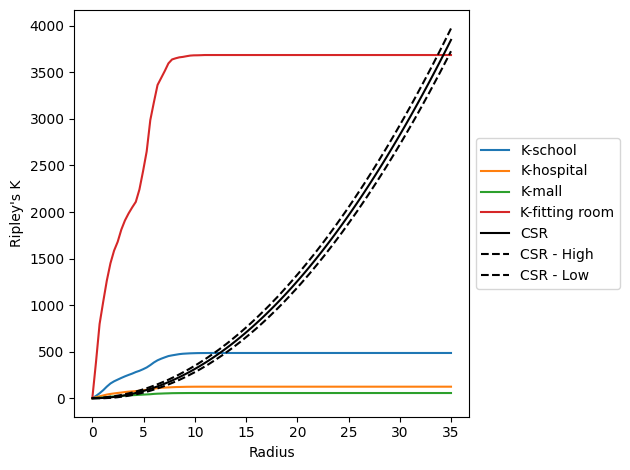

In [2]:
import numpy as np
import requests
import json
from ripleyReference import ripley_k, overpass_url, r, data_mall_1, data_fitting_1, k_mall, k_fitting
import itertools
import matplotlib.pyplot as plt

In [3]:
# Fetching library data
overpass_query = '''
[out:json];
area["ISO3166-2"="US-CA"];
(
  node["amenity"="library"]["name"~"High library"](area);
  way["amenity"="library"]["name"~"High library"](area);
  rel["amenity"="library"]["name"~"High library"](area);
);
out center;
'''
response = requests.get(overpass_url, params={'data': overpass_query})
data_library = response.json()

# Fetching basketball court data
overpass_query = '''
[out:json];
area["ISO3166-2"="US-CA"];
(
  node["leisure"="pitch"]["sport"="basketball"](area);
  way["leisure"="pitch"]["sport"="basketball"](area);
  rel["leisure"="pitch"]["sport"="basketball"](area);
);
out center;
'''
response_basketball = requests.get(overpass_url, params={'data': overpass_query})
data_basketball = response_basketball.json()

In [4]:
def extract_coordinates(data):
    return np.array([[element['lat'], element['lon']] for element in data['elements'] if 'lat' in element and 'lon' in element])

data_library_1 = extract_coordinates(data_library)
data_basketball_1 = extract_coordinates(data_basketball)

In [5]:
k_library = ripley_k(data_library_1, r)
k_basketball = ripley_k(data_basketball_1, r)

/Users/zhaojianbo/Documents/GitHub/Alphabet/ripleyReference.py:227: RuntimeWarning: invalid value encountered in divide
  return k / n


In [6]:
min_lat, max_lat = 32.5, 42.0
min_lon, max_lon = -124.5, -114.0

num_lat_squares = 30
num_lon_squares = 60

lat_step = (max_lat - min_lat) / num_lat_squares
lon_step = (max_lon - min_lon) / num_lon_squares

k_matrix = np.zeros((num_lat_squares, num_lon_squares, 4))

In [7]:
def get_square(lat, lon, min_lat, min_lon, lat_step, lon_step):
    lat_idx = int((lat - min_lat) / lat_step)
    lon_idx = int((lon - min_lon) / lon_step)
    return lat_idx, lon_idx

def assign_k_values(data, k_values, k_index, k_matrix):
    for (lat, lon), k_value in zip(data, k_values):
        lat_idx, lon_idx = get_square(lat, lon, min_lat, min_lon, lat_step, lon_step)
        k_matrix[lat_idx, lon_idx, k_index] += k_value

assign_k_values(data_mall_1, k_mall, 0, k_matrix)
assign_k_values(data_library_1, k_library, 1, k_matrix)
assign_k_values(data_fitting_1, k_fitting, 2, k_matrix)
assign_k_values(data_basketball_1, k_basketball, 3, k_matrix)

In [9]:
def determine_threshold(k_matrix):
    k_values = k_matrix.flatten()
    mean_k = np.mean(k_values)
    std_k = np.std(k_values)
    threshold = mean_k + std_k
    return threshold

threshold = determine_threshold(k_matrix)

In [11]:
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def is_valid_combination(comb, k_matrix, min_lat, min_lon, lat_step, lon_step, threshold):
    seen_blocks = set()
    for place in comb:
        block_index = get_square(place[0], place[1], min_lat, min_lon, lat_step, lon_step)
        if block_index in seen_blocks:
            return False
        if np.any(k_matrix[block_index[0], block_index[1], :] < threshold):
            return False
        seen_blocks.add(block_index)
    return True

def find_shortest_path(malls, libraries, fitting_studios, basketball_courts, k_matrix, min_lat, min_lon, lat_step, lon_step):
    combinations = itertools.product(malls, libraries, fitting_studios, basketball_courts)
    min_distance = float('inf')
    best_path = None
    for comb in combinations:
        if is_valid_combination(comb, k_matrix, min_lat, min_lon, lat_step, lon_step):
            distance = 0
            for i in range(len(comb) - 1):
                current_point = np.array(comb[i])
                next_point = np.array(comb[i+1])
                current_distance = calculate_distance(current_point, next_point)
                distance += current_distance
            if distance < min_distance:
                min_distance = distance
                best_path = comb
    return best_path, min_distance

In [12]:
best_path, min_distance = find_shortest_path(data_mall_1, data_library_1, data_fitting_1, data_basketball_1, k_matrix, min_lat, min_lon, lat_step, lon_step)
print("Best Path:", best_path)
print("Minimum Distance:", min_distance)

Best Path: None
Minimum Distance: inf
